データ処理はscikit-learn, pandas, numpy, matplotlibなど

訓練はtensorflow_decision_forests(TFDF)を使う

動作環境:WSL2上のUbuntu22.04, Anaconda
ローカルGPU環境:Cuda11.8, cudnn8.7

References:
[1]https://www.kaggle.com/code/keishibata/feature-engineering-for-beginners

In [4]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow_decision_forests as tfdf
import datetime
current_directory = os.getcwd()
print(current_directory)

/mnt/f/python/kaggle/Linkingwritingprocess


In [6]:
# スウ環境用
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        print("GPU Device:", device)

Num GPUs Available:  1
GPU Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [7]:
# data loading
train_directory = os.path.join(current_directory, "train_logs.csv")
label_directory = os.path.join(current_directory, "train_scores.csv")
train_dataset = pd.read_csv(train_directory)
label_dataset = pd.read_csv(label_directory)
train_dataset

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1
...,...,...,...,...,...,...,...,...,...,...,...
8405893,fff05981,3615,2063944,2064440,496,Nonproduction,Leftclick,Leftclick,NoChange,1031,240
8405894,fff05981,3616,2064497,2064497,0,Nonproduction,Shift,Shift,NoChange,1031,240
8405895,fff05981,3617,2064657,2064765,108,Replace,q,q,q => q,1031,240
8405896,fff05981,3618,2069186,2069259,73,Nonproduction,Leftclick,Leftclick,NoChange,1028,240


event_idに意味がないので後に消去する

In [8]:
label_dataset

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0
...,...,...
2466,ffb8c745,3.5
2467,ffbef7e5,4.0
2468,ffccd6fd,1.5
2469,ffec5b38,5.0


In [9]:
is_nan = train_dataset.isna().sum()
is_nan
# NaN値が入っていないので欠損値処理不要

id                 0
event_id           0
down_time          0
up_time            0
action_time        0
activity           0
down_event         0
up_event           0
text_change        0
cursor_position    0
word_count         0
dtype: int64

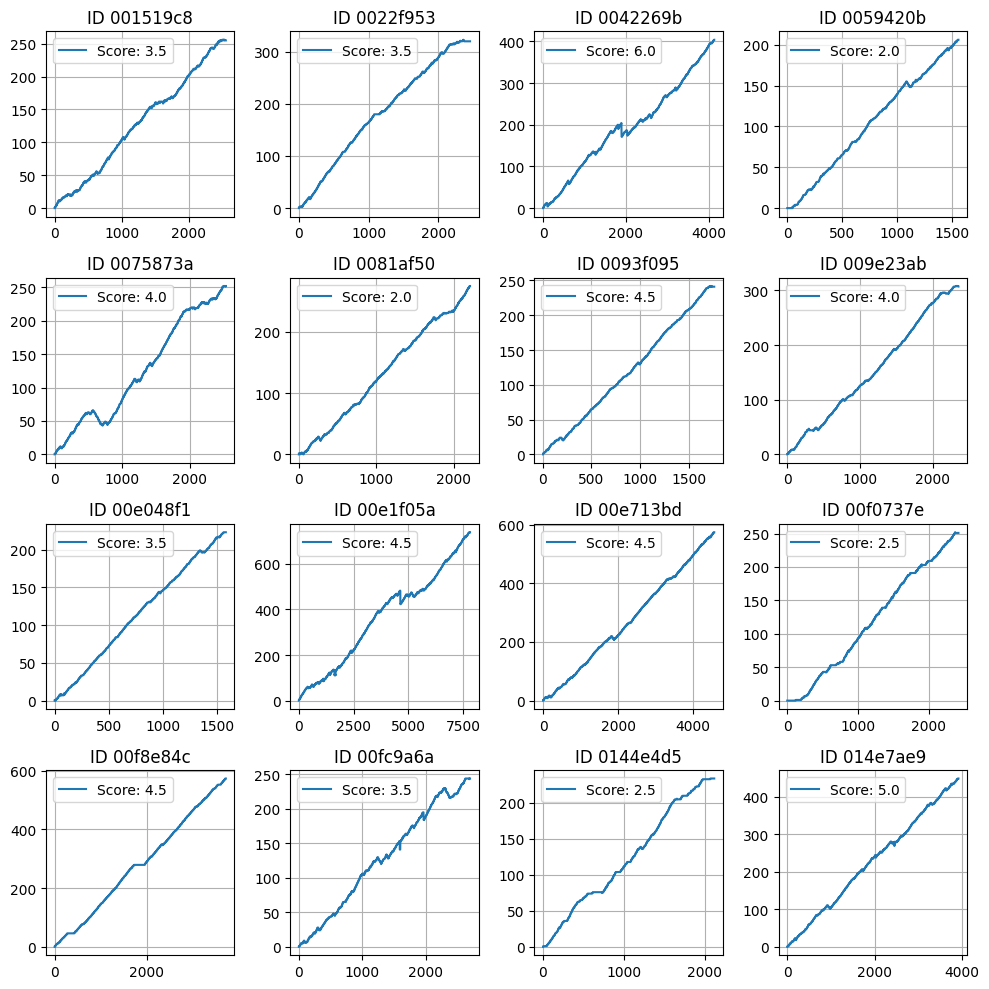

In [11]:
# 時系列データの形をプロットしてみる
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
axes = axes.flatten()

ids = train_dataset["id"].unique()

for u, i in enumerate(ids[:16]):
    steps, pro_plot_df = len(train_dataset[train_dataset["id"]==i]), train_dataset[train_dataset["id"]==i]
    
    ax = axes[u]  # 現在のサブプロット
    ax.plot(list(range(1, steps+1)), pro_plot_df["word_count"], label=f'Score: {label_dataset[label_dataset["id"]==i]["score"].values[0]}')
    ax.grid()
    ax.legend()
    ax.set_title(f'ID {i}')

plt.tight_layout()
plt.show()

振動が強い文章が丁寧に修正されているため点数高い傾向がある？→絶対ではないが、やや相関性ある
<h4>従って、一次関数でシミュレートし、関数からのずれを学習データとして入力することが可能かもしれない  Δ　試したけど→否決します</h4>

相関性はあるけど、feature_engineeringの方法がだめだった

In [315]:
# 時系列データであるため直接使えないかもしれない？
# 字数、時間、時間/字数、leftclik, rightclikの数、一次関数でシミュレートした場合の偏差（平均二乗誤差）などを取り出してたらしいデータセットにしないと上手くいかない気がする。
# 言語モデルも可能かもしれないが、めんどくなりそう

# 従って、down_event, up_eventの中のユニークデータを考察してみる
sum(train_dataset["down_event"] == train_dataset["up_event"]) #マウスかキーボードを押したときと離す時発生するイベントがほぼ全部同じだが、逆に同じでない時は何があった？

8405364

In [316]:
train_dataset[train_dataset["down_event"] != train_dataset["up_event"]] #あんまり意味なさそうだから無視する

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
5115,0042269b,105,104507,104617,110,Replace,q,m,qqqqqqq qqq qqqq qqqq qqqq qq qqqqqqqq qqqqqqq...,1,4
5232,0042269b,222,158578,158638,60,Replace,q,i,qqqqqqq => q,15,14
6276,0042269b,1266,473329,473439,110,Replace,q,o,qqq qq qqq qqqqqqq qqqqqq qqqq qq => q,194,128
6825,0042269b,1815,641821,641920,99,Replace,q,t,qqq qqqqq qq qqqqqqqq qqqq qqq qqqqqqq qq qqqq...,529,190
8223,0042269b,3213,1410198,1410293,95,Replace,q,a,qqqqqqq qqqqqqqqq qqqq qqq qq qqqq qqq qqqqqqq...,1539,282
...,...,...,...,...,...,...,...,...,...,...,...
8323360,fde20dd8,2019,495093,495205,112,Replace,q,i,qqqq => q,530,167
8328686,fde20dd8,7345,1760415,1760572,157,Replace,q,y,qq qqq qqq'q qqqqq qqqqqq qq qqq qqqqqqq => q,3218,700
8378372,ff90a677,29,50477,50647,170,Nonproduction,a,A,NoChange,18,4
8378374,ff90a677,31,50703,50837,134,Replace,q,i,q qq qqqqqqq qqqq => q,1,1


In [18]:
activity_columns = train_dataset["activity"].unique()
# このMove　Fromって要はコピペですね。コピペが多いと点数低いのでは？と思うので、'Nonproduction', 'Input', 'Remove/Cut', 'Replace', 'copyandpaste'の数でまとめてそれぞれ新しいコラム
# を作るのはどう？
print(activity_columns)

['Nonproduction' 'Input' 'Remove/Cut' 'Replace'
 'Move From [284, 292] To [282, 290]' 'Move From [287, 289] To [285, 287]'
 'Move From [460, 461] To [465, 466]' 'Paste'
 'Move From [905, 1314] To [907, 1316]'
 'Move From [565, 743] To [669, 847]' 'Move From [669, 847] To [565, 743]'
 'Move From [1041, 1121] To [1496, 1576]'
 'Move From [1455, 1557] To [1323, 1425]'
 'Move From [2268, 2275] To [2247, 2254]'
 'Move From [213, 302] To [902, 991]' 'Move From [0, 158] To [234, 392]'
 'Move From [460, 465] To [925, 930]' 'Move From [810, 906] To [816, 912]'
 'Move From [186, 187] To [184, 185]' 'Move From [140, 272] To [299, 431]'
 'Move From [114, 140] To [272, 298]'
 'Move From [1386, 1450] To [1445, 1509]'
 'Move From [442, 524] To [296, 378]' 'Move From [408, 414] To [390, 396]'
 'Move From [1144, 1147] To [1142, 1145]'
 'Move From [218, 220] To [206, 208]' 'Move From [164, 165] To [153, 154]'
 'Move From [623, 632] To [624, 633]'
 'Move From [747, 960] To [1041, 1254]'
 'Move From [274,

In [19]:
print(sum(train_dataset["text_change"]=="NoChange"))
# text_changeもほぼNoChangeで埋まっている

703851


In [20]:
len(train_dataset["text_change"].unique())
#　ユニーク操作が多い。これは各自独自のコピペなどの操作を行ってると考えられる。
# ここでは一旦NoChangeとNoChange以外でCountしてみるが、仮説として長い文字列をコンパクト化：qqqqqqqqq→qのようにすることは高いパフォーマンスに繋がるかもしれない。従って、各操作において
# 符号の左側のqと右側のqの比例、あるいは書き換えの数をカウントして新しいfeatureにすると良いかもしれない

4111

In [21]:
text_change_columns = train_dataset["text_change"].unique()

#置き換えを行うが、将来的にはこれより高度なfeature_engineeringが望ましい
train_dataset.loc[~train_dataset['text_change'].isin([text_change_columns[0]]), 'text_change'] = 'Changed'
text_change_columns = train_dataset["text_change"].unique()

11/17 release note:

Because decision forests are not strongly intervened by unimportant features, trying much more features help one understand the model better.

Here, new features are(Refs, [1]):\
1.各idにおけるSpace実行回数(down_eventのSpaceのカウント合計値で作成)\
2.各idにおけるスタートポーズ時間(down_timeの最小値で作成)\
3.各idにおけるシンボルの長さ(cursor_positionの最大値で作成)

In [180]:
# feature engineering
def pipeline(train_dataset, label_dataset):
    start_time = datetime.datetime.now()
    ids = train_dataset["id"].unique()

    words = train_dataset.groupby('id')['word_count'].last().reset_index()
    time = train_dataset.groupby('id')['down_time'].last().reset_index()
    time_per_word = time.copy()
    time_per_word['time_per_word'] = time['down_time'] / words['word_count']
    time_per_word = time_per_word.drop(columns=["down_time"])
    
    words = words.rename(columns={'word_count': 'words'})
    time  = time.rename(columns={'down_time': 'time'})

    # このMove Fromxxxを全部MoveFromに変える
    train_dataset.loc[~train_dataset['activity'].isin(activity_columns[:4]), 'activity'] = 'MoveFrom' 

    # カテゴリ変数の数を新しいコラムに入れた新しいtabularを作る
    activity_count = train_dataset.groupby('id')['activity'].value_counts().unstack(fill_value=0).reset_index()

    # down_eventとup_eventに対しても同じことをやってみるが、ほぼ一緒なので片方を取る
    down_event_count = train_dataset.groupby("id")["down_event"].value_counts().unstack(fill_value=0).reset_index()
    text_change_count = train_dataset.groupby("id")["text_change"].value_counts().unstack(fill_value=0).reset_index()

    # action_timeとcursor_positionに関してとりあえずmeanを使う
    action_time = train_dataset.groupby("id")["action_time"].mean().reset_index()
    cursor_position = train_dataset.groupby("id")["cursor_position"].mean().reset_index()

    # 11/17追加部分
    start_pause = train_dataset.groupby('id')['down_time'].min().reset_index()
    start_pause = start_pause.rename(columns={'down_time': 'start_pause'})

    symbol_length = train_dataset.groupby('id')['cursor_position'].max().reset_index()
    symbol_length = symbol_length.rename(columns={'cursor_position': 'symbol_length'})

    #マージして最終データを整える
    train_ds = train_dataset.drop_duplicates(subset='id')[['id']].reset_index(drop=True)
    train_ds = train_ds.merge(down_event_count, on='id', how='right')
    train_ds = train_ds.merge(text_change_count, on='id', how='right')
    train_ds = train_ds.merge(action_time, on='id', how='right')
    train_ds = train_ds.merge(cursor_position, on='id', how='right')
    train_ds = train_ds.merge(df_tmp, on='id', how='right')
    train_ds = train_ds.merge(activity_count, on='id', how='right')
    train_ds = train_ds.merge(label_dataset, on='id', how='right')
    # labelも忘れずに、TFDFは最後のコラムを自動的にコラム扱いする

    end_time = datetime.datetime.now()

    patterns = [r'\?', r'(%)', r',']  # 置き換えたいパターンをここに追加
    replacements = ['question_mark', 'percentage_mark', 'comma']  # 対応する置き換え文字列をここに追加
    # コラム名を置き換え
    df = train_ds.copy()
    for i in range(len(patterns)):
        df.columns = [re.sub(patterns[i], replacements[i], col) for col in df.columns]

    features = df.columns
    train_ds_tfdf = tfdf.keras.pd_dataframe_to_tf_dataset(df[features[1:]], label="score", 
                                                          task=tfdf.keras.Task.REGRESSION, fix_feature_names=False)
    test_ds_tfdf = tfdf.keras.pd_dataframe_to_tf_dataset(df[features[1:]], label=None, 
                                                      task=tfdf.keras.Task.REGRESSION, fix_feature_names=False)
    print(abs(start_time - end_time))
    return train_ds_tfdf, test_ds_tfdf, df
    
train_ds_tfdf, _, _ = pipeline(train_dataset, label_dataset)

0:00:04.042329


In [ ]:
"""
mse_hypothesis = pd.read_csv("mse_hypothesis.csv")
from sklearn.linear_model import LinearRegression
# このステップは時間がかかるが、実際どれだけ役に立つのかはまだわからない、tfdfの後重要度を出力させてみて、必要な場合は代替案を考えるべき
mse_hypothesis = pd.DataFrame(columns=['id', "intercept", 'mse'])

start_time = datetime.datetime.now()
n = 0
for i in ids:
    n = 1 + n
    if n%100 == 0:
        print("loop:", n)
    steps, col = len(train_dataset[train_dataset["id"]==i]), train_dataset[train_dataset["id"]==i]
    x = np.array(list(range(1, steps+1)))
    y = np.array(col["word_count"])
    
    reg = LinearRegression().fit(x.reshape(-1, 1), y)
    
    slope = reg.coef_[0] #このslopeは各ステップ書く文字数に関連する
    intercept = reg.intercept_

    predicted_y = slope * x + intercept
    residuals = y - predicted_y
    mse = np.mean(residuals**2)
    new_col = pd.DataFrame({'id': [i], 'intercept': [intercept], 'mse': [mse]})
    mse_hypothesis = pd.concat([mse_hypothesis, new_col], axis=0)
    
end_time = datetime.datetime.now()
print(abs(start_time - end_time))

train_ds = train_ds.merge(mse_hypothesis, on='id', how='right')
"""

In [181]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [182]:
tuner = tfdf.tuner.RandomSearch(num_trials=20)

tuner.choice("num_trees", [330, 340, 350])

local_search_space = tuner.choice("growing_strategy", ["LOCAL"])
local_search_space.choice("max_depth", [16, 17])

global_search_space = tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"], merge=True)
global_search_space.choice("max_num_nodes", [300, 340, 360])

model = tfdf.keras.GradientBoostedTreesModel(tuner=tuner, task=tfdf.keras.Task.REGRESSION)
model.compile(metrics=["rmse"])
model.fit(x=train_ds_tfdf)

Use /tmp/tmp0kcs480e as temporary training directory
Reading training dataset...


[WARNING 23-11-18 02:04:49.8864 JST gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-11-18 02:04:49.8864 JST gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-11-18 02:04:49.8864 JST gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.803883. Found 2471 examples.
Training model...
Model trained in 0:00:03.392035
Compiling model...


[INFO 23-11-18 02:04:54.0872 JST kernel.cc:1233] Loading model from path /tmp/tmp0kcs480e/model/ with prefix 89076344170740ba
[INFO 23-11-18 02:04:54.0899 JST quick_scorer_extended.cc:903] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 23-11-18 02:04:54.0903 JST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-11-18 02:04:54.0903 JST kernel.cc:1061] Use fast generic engine


Model compiled.


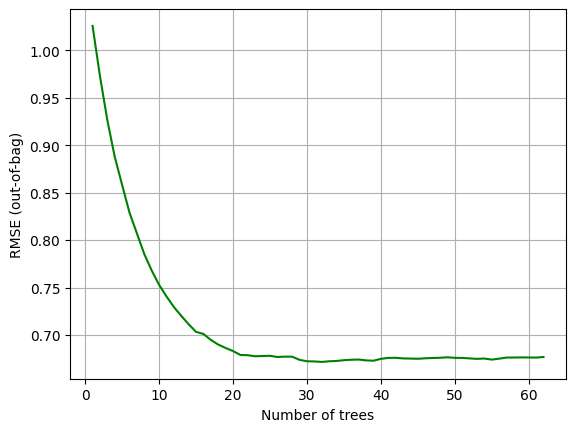

In [183]:
logs = model.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs ], [log.evaluation.rmse for log in logs ], color="g")
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.grid(True)
plt.show()

In [184]:
print(model.summary())

Model: "gradient_boosted_trees_model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (141):
	!
	"
	#
	$
	&
	'
	(
	)
	*
	+
	-
	.
	/
	0
	1
	2
	5
	:
	;
	<
	=
	>
	@
	A
	Alt
	AltGraph
	ArrowDown
	ArrowLeft
	ArrowRight
	ArrowUp
	AudioVolumeDown
	AudioVolumeMute
	AudioVolumeUp
	Backspace
	C
	Cancel
	CapsLock
	Changed
	Clear
	ContextMenu
	Control
	Dead
	Delete
	End
	Enter
	Escape
	F
	F1
	F10
	F11
	F12
	F15
	F2
	F3
	F6
	Home
	I
	Input
	Insert
	Leftclick
	M
	MediaPlayPause
	MediaTrackNext
	MediaTrackPrevious
	Meta
	Middleclick
	ModeChange
	MoveFrom
	NoChange
	Nonproduction
	NumLock
	OS
	PageDown
	PageUp
	Pause
	Process
	Remove/Cut
	Replace
	Rightclick
	S
	ScrollLock
	Shi

In [185]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

リストとして重要度を取り出して重要ではない要素を取り消して再訓練

In [198]:
importance_dict = model.make_inspector().variable_importances()
importance_list = []
for key in importance_dict['INV_MEAN_MIN_DEPTH']:
    text_portion = str(key[:1]).split(" ")[0][1:]
    importance_list.append(text_portion)
importance_list = [item.strip('"') for item in importance_list]
print(importance_list)

['q', 'comma', 'cursor_position', 'Enter', 'Shift', '-', 'Input', 'Space', '.', 'Changed', 'Remove/Cut', 'action_time', 'start_pause', 'Backspace', 'question_mark', "'", 'ArrowLeft', 'CapsLock', 'Leftclick', 'Insert', 'Nonproduction', '!', 'Tab', 'NoChange', 'ArrowDown', 'ArrowRight', 'Replace', '[', 'AudioVolumeDown', ':', ';', '', '\\', '=', ')', 'Control', 'End', 'Rightclick', 'Delete', 'ArrowUp', 'c', 'AudioVolumeUp', '(', 'Home', '/', 'MoveFrom', 'a', '#']


In [199]:
importance_list[11]

'action_time'

In [200]:
_, _, df = pipeline(train_dataset, label_dataset)
columns_to_keep = importance_list + ["id", "score"]
columns_to_keep = [col for col in columns_to_keep if col]
df = df[columns_to_keep]
   
features = df.columns
train_ds_tfdf = tfdf.keras.pd_dataframe_to_tf_dataset(df[features[1:]], label="score", 
                                                          task=tfdf.keras.Task.REGRESSION, fix_feature_names=False)

0:00:04.171643


Use /tmp/tmp2lgwg0zg as temporary training directory
Reading training dataset...


[WARNING 23-11-18 02:21:14.7385 JST gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-11-18 02:21:14.7385 JST gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-11-18 02:21:14.7385 JST gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.326768. Found 2471 examples.
Training model...
Model trained in 0:00:02.825427
Compiling model...
Model compiled.


[INFO 23-11-18 02:21:17.9028 JST kernel.cc:1233] Loading model from path /tmp/tmp2lgwg0zg/model/ with prefix 13787cc2efe345b6
[INFO 23-11-18 02:21:17.9045 JST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-11-18 02:21:17.9045 JST kernel.cc:1061] Use fast generic engine


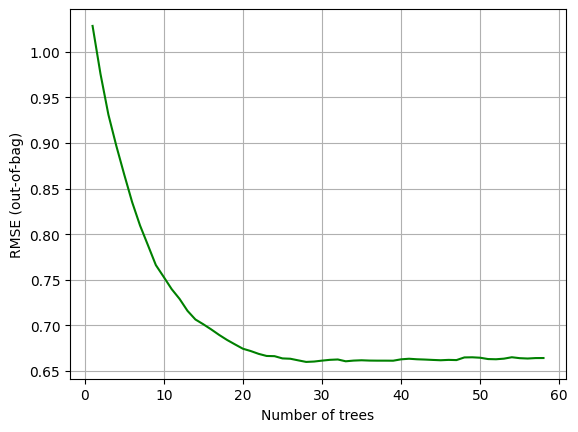

In [203]:
#二度目の訓練
tuner = tfdf.tuner.RandomSearch(num_trials=20)

tuner.choice("num_trees", [330, 340, 350])

local_search_space = tuner.choice("growing_strategy", ["LOCAL"])
local_search_space.choice("max_depth", [16, 17])

global_search_space = tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"], merge=True)
global_search_space.choice("max_num_nodes", [300, 340, 360])

model = tfdf.keras.GradientBoostedTreesModel(tuner=tuner, task=tfdf.keras.Task.REGRESSION)
model.compile(metrics=["rmse"])
model.fit(x=train_ds_tfdf)
logs = model.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs ], [log.evaluation.rmse for log in logs ], color="g")
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.grid(True)
plt.show()

普通のRandomForestModelの方がRMSE低かったけど正直パフォーマンスが良くない

scikitlearnでのXGBoostなどのコードを追加して頂けると助かる

ほかのfeature engineering手法の提案もお願いします。

In [204]:
tuner = tfdf.tuner.RandomSearch(num_trials=30)

# Hyper-parameters to optimize.
tuner.choice("max_depth", [16,17,18])
tuner.choice("num_trees", [320,330,340])

local_search_space = tuner.choice("growing_strategy", ["LOCAL"])
global_search_space = tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"], merge=True)
global_search_space.choice("max_num_nodes", [256, -1])

model = tfdf.keras.RandomForestModel(tuner=tuner, task=tfdf.keras.Task.REGRESSION)
model.compile("rmse")
model.fit(x = train_ds_tfdf)

Use /tmp/tmprqzp78mu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.352892. Found 2471 examples.
Training model...
Model trained in 0:00:09.570335
Compiling model...


[INFO 23-11-18 02:21:37.4909 JST kernel.cc:1233] Loading model from path /tmp/tmprqzp78mu/model/ with prefix d3659cca156b4333
[INFO 23-11-18 02:21:37.6680 JST decision_forest.cc:660] Model loaded with 330 root(s), 240352 node(s), and 46 input feature(s).
[INFO 23-11-18 02:21:37.6681 JST abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 23-11-18 02:21:37.6681 JST kernel.cc:1061] Use fast generic engine


Model compiled.


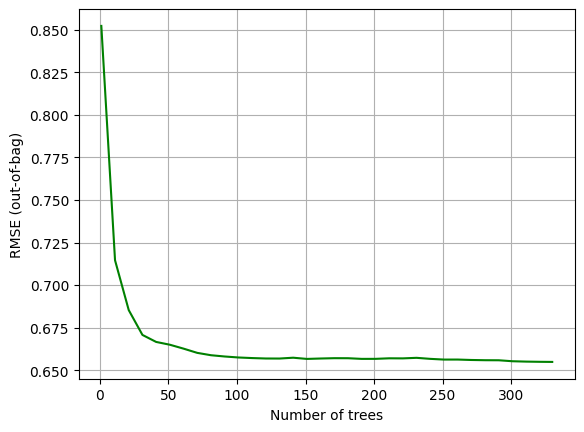

In [205]:
logs = model.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs ], [log.evaluation.rmse for log in logs ], color="g")
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.grid(True)
plt.show()

In [78]:
print(model.summary())

Model: "random_forest_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (141):
	!
	"
	#
	$
	&
	'
	(
	)
	*
	+
	-
	.
	/
	0
	1
	2
	5
	:
	;
	<
	=
	>
	@
	A
	Alt
	AltGraph
	ArrowDown
	ArrowLeft
	ArrowRight
	ArrowUp
	AudioVolumeDown
	AudioVolumeMute
	AudioVolumeUp
	Backspace
	C
	Cancel
	CapsLock
	Changed
	Clear
	ContextMenu
	Control
	Dead
	Delete
	End
	Enter
	Escape
	F
	F1
	F10
	F11
	F12
	F15
	F2
	F3
	F6
	Home
	I
	Input
	Insert
	Leftclick
	M
	MediaPlayPause
	MediaTrackNext
	MediaTrackPrevious
	Meta
	Middleclick
	ModeChange
	MoveFrom
	NoChange
	Nonproduction
	NumLock
	OS
	PageDown
	PageUp
	Pause
	Process
	Remove/Cut
	Replace
	Rightclick
	S
	ScrollLock
	Shift
	Space
	T
	Tab
	

Submission creation

In [ ]:
def pipeline()

In [ ]:
X_train_all = train_data.drop(columns=['id', 'score', 'most_frequent_activity'])
y_train_all = train_data['score']

X_test = test_features.drop(columns=['id', 'most_frequent_activity'])
test_predictions = best_model.predict(X_test)

# สร้างไฟล์ submission DataFrame
submission = pd.DataFrame({
    'id': test_features['id'],
    'score': test_predictions
})

submission.head()
submission.to_csv('submission.csv', index=False)
print('Sucessfully submited')